### Investigation into normalizing RKHS vectors for non landmark proteins

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import os, sys
sys.path.append(os.getcwd() + "/../src")

%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import handl
import util
from collections import defaultdict

In [2]:
def plot(scores_and_labels, xlabel,
         xmin=0.0, 
         xmax=0.6, 
         smoothness=20., 
         font_size=12, 
         line_width=2):
    from sklearn import neighbors

    # create and save plot
    plt.figure()
    
    # create kernel density estimator
    kde = neighbors.KernelDensity(kernel='gaussian', bandwidth = xmax / smoothness)
    # need to add another dimension as required by sklearn
    # arrays passed to kde must be 2-dimensional
    X_plot = np.reshape(np.linspace(xmin, xmax, 500), (-1, 1))
    styles = ['-', '--', '-.', ':']
    for i, (xs, label) in enumerate(scores_and_labels):
        scores = np.ravel(xs) if len(xs) < 1e5 else np.random.choice(np.ravel(xs), int(1e5))
        kde.fit(np.reshape(scores, (-1, 1)))
        densities = kde.score_samples(X_plot)
        plt.plot(X_plot[:,0], np.exp(densities), lw = line_width,
                 label = label, ls=styles[i % len(styles)])
    plt.ylabel('Density', size = font_size)
    plt.xlabel(xlabel, size = font_size)
    plt.legend(loc='best', fontsize = font_size)

In [3]:
sp_ppi_path = "../data/ppi/biogrid/sp/sp-biogrid.v3.4.157-ppi-std.tsv" 
sc_ppi_path = "../data/ppi/biogrid/sc/sc-biogrid.v3.4.157-ppi-std.tsv" 
sc_G = util.simple_two_core(nx.read_edgelist(sc_ppi_path, encoding='ascii'), verbose=False)
sp_G = util.simple_two_core(nx.read_edgelist(sp_ppi_path, encoding='ascii'), verbose=False)

In [4]:
homologs_path = "../data/homologs/sc-sp/sp-sc-homologs.txt" 

In [5]:
source_G, target_G = sp_G, sc_G
homologs = handl.homologs_in_graphs(source_G, target_G, util.read_homolog_list(homologs_path))

In [6]:
source_L = nx.laplacian_matrix(source_G, sorted(source_G.nodes())).todense()
target_L = nx.laplacian_matrix(target_G, sorted(target_G.nodes())).todense()

source_lam = 0.005
target_lam = 0.0005
print(source_L.shape)
print('Source laplacian condition number', np.linalg.cond((np.eye(len(source_L)) - source_lam * source_L)))
print('Target  laplacian condition number', np.linalg.cond(np.eye(len(target_L)) - target_lam * target_L))
source_nodes, target_nodes = sorted(source_G.nodes()), sorted(target_G.nodes())
source_D = handl.regularized_laplacian(source_G, source_nodes, source_lam)
target_D = handl.regularized_laplacian(target_G, target_nodes, target_lam)

print('Source regularized laplacian condition number', np.linalg.cond(source_D))
print('Target  regularized laplacian condition number', np.linalg.cond(target_D))
source_nodes, target_nodes = sorted(source_G.nodes()), sorted(target_G.nodes())


(1865, 1865)
Source laplacian condition number 33.506611680545454
Target  laplacian condition number 52.6153691051292
Source regularized laplacian condition number 2.325315117426557
Target  regularized laplacian condition number 2.5110027954907266


In [7]:
source_C = handl.rkhs_factor(source_D)
target_C = handl.rkhs_factor(target_D)

In [8]:
source_n2i = dict((n,i) for i, n in enumerate(source_nodes))
target_n2i = dict((n,i) for i, n in enumerate(target_nodes))

In [9]:
n_landmarks = 400
homolog_idxs = [(source_n2i[s], target_n2i[t]) for (s,t) in homologs]
landmark_idxs = homolog_idxs[:400]
source_landmark_idxs, target_landmark_idxs = zip(*landmark_idxs)


In [10]:
source_D_L = source_D[source_landmark_idxs, :]
target_D_L = target_D[target_landmark_idxs, :]

In [11]:
def non_landmark_idxs(n, landmark_idxs):
    return [i for i in range(n) if i not in set(landmark_idxs)]
source_non_landmark_idxs = non_landmark_idxs(len(source_G), source_landmark_idxs)
target_non_landmark_idxs = non_landmark_idxs(len(target_G), target_landmark_idxs)


We can compare mean of similarity scores...

In [12]:
source_mean = np.mean(np.ravel(source_D))
target_mean = np.mean(np.ravel(target_D))
source_norm = np.linalg.norm(source_D)
target_norm = np.linalg.norm(target_D)

print('SOURCE elementwise mean:', source_mean)
print('TARGET elementwise mean:', target_mean)
print('SOURCE frobenius norm:', source_norm)
print('TARGET frobenius norm:', target_norm)

print('elementwise mean ratio:', source_mean / target_mean)
print('Frobeniums norm ratio:', source_norm / target_norm)

SOURCE elementwise mean: 0.0005361930294906165
TARGET elementwise mean: 0.00017828489926903222
SOURCE frobenius norm: 41.69536549989926
TARGET frobenius norm: 73.76569302661062
elementwise mean ratio: 3.0075067024128623
Frobeniums norm ratio: 0.5652406123922384


In [13]:
source_mean = np.mean(np.ravel(source_D_L))
target_mean = np.mean(np.ravel(target_D_L))
source_norm = np.linalg.norm(source_D_L)
target_norm = np.linalg.norm(target_D_L)

print('SOURCE elementwise mean:', source_mean)
print('TARGET elementwise mean:', target_mean)
print('SOURCE frobenius norm:', source_norm)
print('TARGET frobenius norm:', target_norm)

print('elementwise mean ratio:', source_mean / target_mean)
print('Frobeniums norm ratio:', source_norm / target_norm)

SOURCE elementwise mean: 0.0005361930294906166
TARGET elementwise mean: 0.00017828489926903184
SOURCE frobenius norm: 19.36633293945371
TARGET frobenius norm: 19.380795905228993
elementwise mean ratio: 3.0075067024128694
Frobeniums norm ratio: 0.9992537475836386


In [14]:
### Plotting distribution of values in regularized laplacians and row and column sums

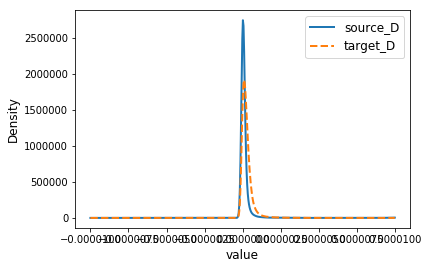

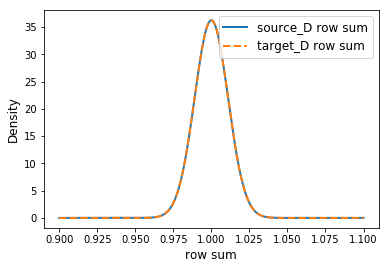

In [15]:
plot([(np.ravel(source_D), 'source_D'), 
      (np.ravel(target_D), 'target_D')], 'value', xmin = -0.00001, xmax=0.00001, smoothness=100)
plot([(np.ravel(np.sum(source_D, axis=1)), 'source_D row sum'), 
      (np.ravel(np.sum(target_D, axis=1)), 'target_D row sum')], 'row sum', xmin = 0.9, xmax=1.1, smoothness=100)

In [16]:
source_C, target_C_hat = handl.handl_embed_matrices(source_C, target_D, landmark_idxs)

In [17]:
source_C_row_norms = np.ravel(np.linalg.norm(source_C, axis=1))
target_C_hat_row_norms = np.ravel(np.linalg.norm(target_C_hat, axis=1))
target_C_row_norms = np.ravel(np.linalg.norm(target_C, axis=1))

In [18]:
def mmm(arr):
    return np.min(arr), np.mean(arr), np.max(arr)
print('Source C row norms:', mmm(source_C_row_norms))
print('Target C row norms:', mmm(target_C_row_norms))
print('Target C hat row norms:', mmm(target_C_hat_row_norms))
print('Target C hat row norms:', mmm(np.take(target_C_hat_row_norms, target_landmark_idxs)))
print('Target C hat row norms:', mmm(np.take(target_C_hat_row_norms, target_non_landmark_idxs)))

Source C row norms: (0.6574371080734505, 0.9815499793466935, 0.9950616378022349)
Target C row norms: (0.6312258433515638, 0.9920927084682118, 0.9995006211884376)
Target C hat row norms: (7.636038224118655e-06, 1.013525691054173, 6.684988752334368)
Target C hat row norms: (0.45089352928869425, 0.9844889562337289, 1.1709459270556895)
Target C hat row norms: (7.636038224118655e-06, 1.015755426882197, 6.684988752334368)


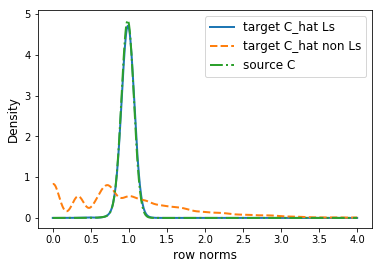

In [30]:
plot([(np.take(target_C_hat_row_norms, target_landmark_idxs), 'target C_hat Ls'),
      (np.take(target_C_hat_row_norms, target_non_landmark_idxs), 'target C_hat non Ls'),
      (source_C_row_norms, 'source C')], 'row norms', xmin=0, xmax=4, smoothness=50)

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)

In [21]:
all_vecs = np.concatenate((source_C, target_C_hat))
print(all_vecs.shape, 1865 + 5609)

(7474, 1865) 7474


In [22]:
pca.fit(source_C)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [23]:
### Normalization
c2h = np.copy(target_C_hat)
c2h[target_non_landmark_idxs] /= np.mean(np.linalg.norm(c2h[target_non_landmark_idxs, :], axis=1))
c2h[target_non_landmark_idxs] *= np.mean(np.linalg.norm(c2h[target_landmark_idxs, :], axis=1))

# PCA 
source_C_pcs = pca.transform(source_C)
target_C_hat_pcs = pca.transform(target_C_hat)
normalized_target_C_hat_pcs = pca.transform(c2h)

print(target_C_hat_pcs.shape)

(5609, 4)


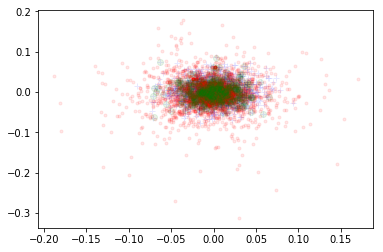

In [24]:
i, j = 0, 3
plt.plot(source_C_pcs[:,i], source_C_pcs[:,j], 'b+',
         #target_C_hat_pcs[target_landmark_idxs,0], target_C_hat_pcs[target_landmark_idxs,1], 'r.',
         target_C_hat_pcs[target_non_landmark_idxs,i], target_C_hat_pcs[target_non_landmark_idxs,j], 'r.',
         target_C_hat_pcs[target_landmark_idxs,i], target_C_hat_pcs[target_landmark_idxs,j], 'go',
         alpha=0.09)#, t, t**2, 'bs', t, t**3, 'g^')

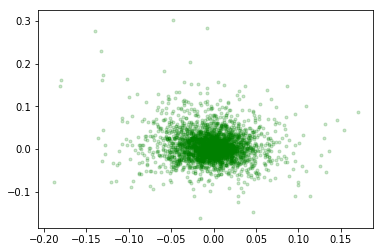

In [25]:
plt.plot(target_C_hat_pcs[target_non_landmark_idxs,0], target_C_hat_pcs[target_non_landmark_idxs,1], 'g.',
         alpha=0.2)#, t, t**2, 'bs', t, t**3, 'g^')

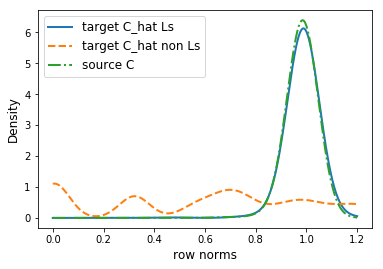

In [26]:
normalized_row_norms = np.linalg.norm(c2h, axis=1)

plot([(np.take(normalized_row_norms, target_landmark_idxs), 'target C_hat Ls'),
      (np.take(normalized_row_norms, target_non_landmark_idxs), 'target C_hat non Ls'),
      (source_C_row_norms, 'source C')], 'row norms', xmin=0, xmax=1.2)

In [27]:
### OLD CODE/IDEAS

## some old code that applies CORAL to colorize non-landmark protein RKHS with covariance of the landmark proteins RKHS

# normalized_target_C_hat = np.copy(target_C_hat)

# # TAKE AWAY THE MEAN
# normalized_target_C_hat[target_non_landmark_idxs,:] -= \
#     np.mean(normalized_target_C_hat[target_non_landmark_idxs, :], axis=0)
# print(np.linalg.norm(np.mean(normalized_target_C_hat[target_non_landmark_idxs, :], axis=0)))

# # Applying CORAL to non landmark vectors
# C_L = np.cov(normalized_target_C_hat[target_landmark_idxs,:].T)
# C_NonL = np.cov(normalized_target_C_hat[target_non_landmark_idxs,:].T)
# H = handl.rkhs_factor(np.linalg.inv(C_NonL + 0.05 * np.eye(len(C_L)))) \
#     @ handl.rkhs_factor(C_NonL + 0.05* np.eye(len(C_L)))
# normalized_target_C_hat[target_non_landmark_idxs,:] = normalized_target_C_hat[target_non_landmark_idxs,:] @ H

# # ADD NEW MEAN
# normalized_target_C_hat[target_non_landmark_idxs,:] += np.mean(target_C_hat[target_landmark_idxs, :], axis=0)

# print(np.linalg.norm(np.mean(normalized_target_C_hat[target_landmark_idxs, :], axis=0) - 
#                      np.mean(normalized_target_C_hat[target_non_landmark_idxs, :], axis=0)))

# print(mmm(np.linalg.norm(normalized_target_C_hat[target_landmark_idxs, :], axis=1)))
# print(mmm(np.linalg.norm(normalized_target_C_hat[target_non_landmark_idxs, :], axis=1)))
# print(mmm(np.linalg.norm(source_C, axis=1)))


# normalized_target_C_hat_row_norms = np.ravel(np.linalg.norm(normalized_target_C_hat, axis=1))

# plot([(np.take(normalized_target_C_hat_row_norms, target_landmark_idxs), 'target C_hat Ls'),
#       (np.take(normalized_target_C_hat_row_norms, target_non_landmark_idxs), 'target C_hat non Ls'),
#       (source_C_row_norms, 'source C')], 'row norms', xmin=0, xmax=1.2)